In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pickle

# Custom imports
import sys
sys.path.insert(0, "../")
from plots import plot_single_sample, plot_matrix
from utils import load_model, grid_plot
from attacks import validate

def load_valid(paths, dataset, model):
    p = paths[(dataset, model)]
    with open(p['sample'], 'rb') as handle:
        file = pickle.load(handle)
    raw_labels_origin = file['data']['labels_origin']
    raw_labels_target = file['data']['labels_target']
    raw_preds = file['data']['preds']
    ratio = file['meta']['args']['goal_ratio']
    valid = validate(raw_preds, raw_labels_origin, raw_labels_target, ratio, tolerance=0.05)
    return file, valid

def load_selection(paths, dataset, model, device='cuda', samples=None):
    file, valid = load_valid(paths, dataset, model)
    p = paths[(dataset, model)]
    generator = load_model(p['generator'], device=device)
    if samples is None:
        selection = p['selection']
    else:
        labels = file['data']['labels_origin'][valid]
        selection = np.concatenate([np.where(labels == cls)[0][:samples] for cls in range(10)])

    # Decode images
    data = {}
    z_perturbed = file['data']['z_perturbed'][valid][selection]
    imgs = generator.decode(torch.tensor(z_perturbed, device=device))
    data['imgs'] = imgs.detach().cpu().numpy()

    # Helper data
    data['labels_origin'] = file['data']['labels_origin'][valid][selection]
    data['labels_target'] = file['data']['labels_target'][valid][selection]
    data['preds'] = file['data']['preds'][valid][selection]
    data['class_map'] = p['class_map']
    data['dataset'] = dataset
    data['model'] = model
    return data

def get_matrix(paths, dataset, model, samples=1000, xlabel='Original class', ylabel='Final class', include_fails=False):
    f, valid = load_valid(paths, dataset, model)
    labels = paths[(dataset, model)]['class_map']
    df = pd.DataFrame({
        'valid': valid,
        xlabel : f['data']['labels_origin'],
        ylabel : f['data']['labels_target']
    })

    matrix = df.groupby([xlabel, ylabel]).sum()
    matrix = matrix.unstack().fillna(0)
    matrix.columns = matrix.columns.droplevel(0)
    matrix.columns = pd.Index(labels, name=matrix.columns.name)
    matrix.index = pd.Index(labels, name=matrix.index.name)
    
    # Add fails
    if include_fails:
        matrix['Fail'] = samples - matrix.sum(axis=1)
    matrix = (matrix/samples) * 100 # Percentages
    return matrix.T


# Interpolation method

In [2]:
paths_int = {
    ('CIFAR10', 'DCGAN'): {
        'generator': r'..\runs\cifar10\dcgan-cifar',
        'sample': '..\samples\int_sample_0-3_dcgan-cifar_999.pickle',
        'class_map': ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
        'selection': [
                1277,  829,  753,    # airplane
                2306, 2150, 2832,    # car
                4135, 3274, 3358,    # bird
                5110, 4985, 5275,    # cat
                7608, 6162, 7663,    # deer
                8905, 8728, 8911,    # dog
                10205,  9425, 10577, # frog
                11310, 11696, 11638, # horse
                12824, 12649, 12323, # ship
                14317, 14592, 14552, # truck 
            ]

    },
    ('CIFAR10', 'ALI'): {
        'generator': r'..\runs\cifar10\ali-cifar',
        'sample': '..\samples\int_sample_0-3_ali-cifar_999.pickle',
        'class_map': ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
        'selection': [
                964, 1071, 1574,     # airplane
                2485, 2648, 2973,    # car
                3561, 3641, 3550,    # bird
                5375, 5781, 6258,    # cat
                7500, 6914, 7691,    # deer
                9079, 9352, 9979,    # dog
                11234, 10374, 11930, # frog
                12313, 12287, 12992, # horse
                13942, 13564, 13692, # ship
                15874, 16273, 17100, # truck
            ]

    },
    ('SVHN', 'ALI'): {
        'generator': r'..\runs\svhn\ali-svhn',
        'sample': '..\samples\int_sample_0-3_ali-svhn_999.pickle',
        'class_map': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        'selection': [
                1442, 1391, 1312,    # Digit 0
                2592, 3214, 2754,    # Digit 1
                5168, 4850, 4936,    # Digit 2
                6218, 7787, 7826,    # Digit 3
                8993, 8174, 9338,    # Digit 4
                11073, 10084, 11179, # Digit 5
                12762, 12731, 12332, # Digit 6
                14658, 14068, 14313, # Digit 7
                16622, 16381, 15347, # Digit 8
                17877, 18605, 18611, # Digit 9
            ]
    },
    ('SVHN', 'DCGAN'): {
        'generator': r'..\runs\svhn\dcgan-svhn',
        'sample': '..\samples\int_sample_0-3_dcgan-svhn_999.pickle',
        'class_map': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        'selection': [
                1574, 1589, 1733,    # Digit 0
                3910, 4347, 4090,    # Digit 1
                6717, 6199, 6502,    # Digit 2
                9365, 7426, 8943,    # Digit 3
                10325, 10280, 10887, # Digit 4
                12371, 12438, 12683, # Digit 5
                13404, 15219, 15371, # Digit 6
                15761, 17068, 16456, # Digit 7
                19318, 18765, 18966, # Digit 8
                19933, 20153, 20056, # Digit 9
            ]
    },
    ('SVHN', 'VAE'): {
        'generator': r'..\runs\svhn\vae-svhn',
        'sample': '..\samples\int_sample_0-3_vae-svhn_999.pickle',
        'class_map': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        'selection': [
                1569, 1490, 1343,    # Digit 0
                3614, 2715, 2319,    # Digit 1
                5302, 5355, 4374,    # Digit 2
                7468, 7691, 7650,    # Digit 3
                8463, 9243, 9033,    # Digit 4
                10626, 10470, 10318, # Digit 5
                11175, 12095, 12642, # Digit 6
                13601, 13966, 13258, # Digit 7
                16049, 15979, 15693, # Digit 8
                17652, 18210, 17561, # Digit 9
            ]
    },
    ('MNIST', 'ALI'): {
        'generator': r'..\runs\mnist\ali-mnist',
        'sample': '..\samples\int_sample_0-3_ali-mnist_999.pickle',
        'class_map': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        'selection': [
                2407, 2727, 3219,    # Digit 0
                5795, 5875, 5916,    # Digit 1
                7921, 9516, 7815,    # Digit 2
                11574, 11775, 11472, # Digit 3
                14761, 15037, 14734, # Digit 4
                20262, 18023, 20299, # Digit 5
                23765, 23055, 23650, # Digit 6
                25235, 25212, 25196, # Digit 7
                27608, 30001, 29261, # Digit 8
                32546, 33759, 34470, # Digit 9
            ]
    },
    ('MNIST', 'DCGAN'): {
        'generator': r'..\runs\mnist\dcgan-mnist',
        'sample': '..\samples\int_sample_0-3_dcgan-mnist_999.pickle',
        'class_map': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        'selection': [
                1634, 2856, 2199,    # Digit 0
                5224, 3773, 5475,    # Digit 1
                7782, 10053, 7905,   # Digit 2
                11250, 10627, 11727, # Digit 3
                14615, 14411, 13614, # Digit 4
                19882, 19632, 19910, # Digit 5
                20362, 20204, 20682, # Digit 6
                25204, 25172, 24852, # Digit 7
                27475, 29086, 28771, # Digit 8
                34521, 32747, 33325, # Digit 9
            ]
    },
    ('MNIST', 'VAE'): {
        'generator': r'..\runs\mnist\vae-mnist',
        'sample': '..\samples\int_sample_0-3_vae-mnist_999.pickle',
        'class_map': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        'selection': [
                1634, 1536, 1589,    # Digit 0
                3679, 3918, 4087,    # Digit 1
                7292, 7001, 4938,    # Digit 2
                9160, 9297, 9250,    # Digit 3
                12609, 11224, 11042, # Digit 4
                15106, 14420, 15101, # Digit 5
                15616, 17465, 17377, # Digit 6
                19393, 18690, 19196, # Digit 7
                23369, 22442, 22815, # Digit 8
                27229, 26928, 27142, # Digit 9
        ]
    }
}

### Success rate

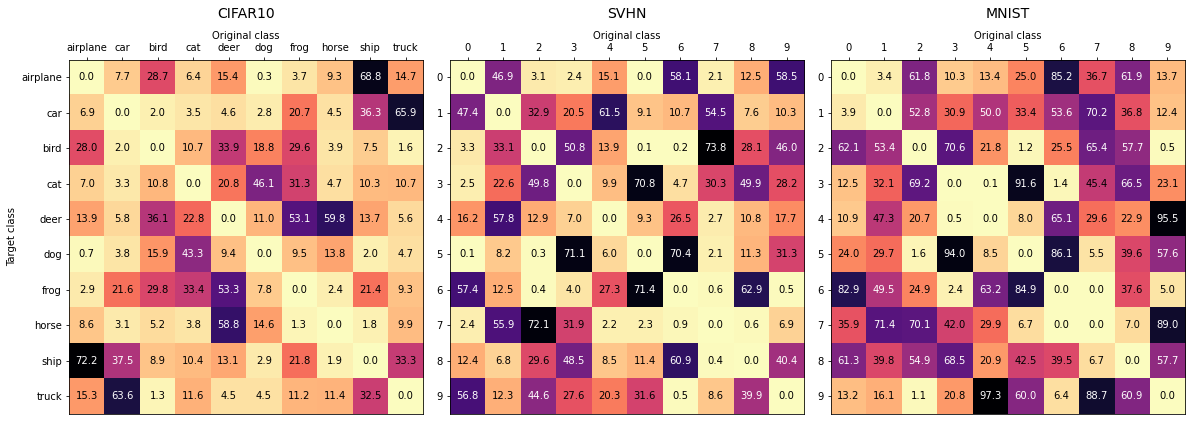

In [3]:
fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(1, 3)
gs.update(wspace=0.075)

ax0 = fig.add_subplot(gs[0])
dataset = 'CIFAR10'
matrix = get_matrix(paths_int, dataset, 'DCGAN', ylabel='Target class')
plot_matrix(ax0, matrix, title=dataset)

ax1 = fig.add_subplot(gs[1])
dataset = 'SVHN'
matrix = get_matrix(paths_int, dataset, 'DCGAN', ylabel='')
plot_matrix(ax1, matrix, title=dataset)

ax2 = fig.add_subplot(gs[2])
dataset = 'MNIST'
matrix = get_matrix(paths_int, dataset, 'DCGAN', ylabel='')
plot_matrix(ax2, matrix, title=dataset)

fig.savefig('figures/int_success_matrix.png', bbox_inches='tight')

### Selected adversarial examples

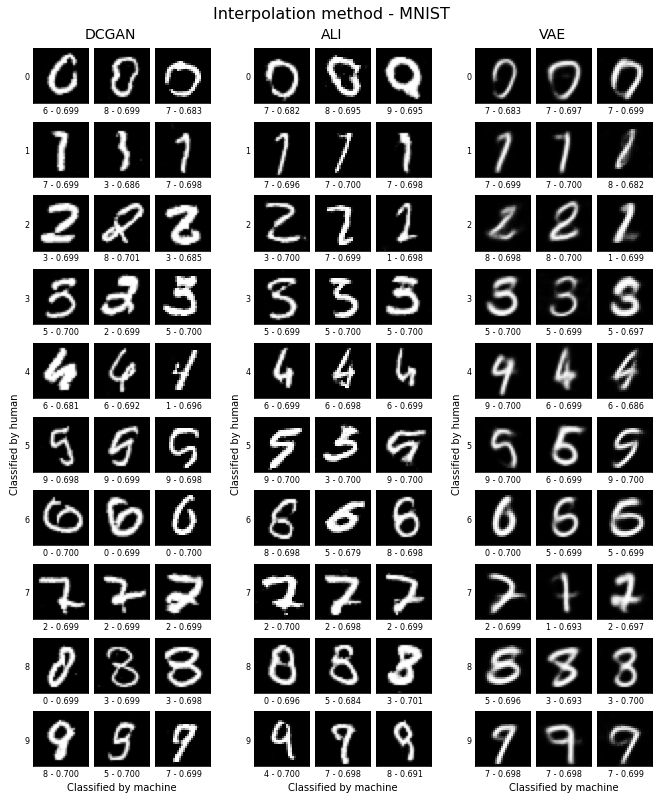

In [4]:
rows=10
cols=3
labelfont=8

# gridspec inside gridspec
fig = plt.figure(constrained_layout=True, figsize=(9, 11))
subfigs = fig.subfigures(1, 3, wspace=0.07)

data = load_selection(paths_int, 'MNIST', 'DCGAN')
for i in range(rows*cols):
    ax = subfigs[0].add_subplot(rows, cols, i+1)
    ax = plot_single_sample(ax, i, rows, cols, data, labelfont, grayscale=True)
subfigs[0].suptitle(f"{data['model']}", size=14)

data = load_selection(paths_int, 'MNIST', 'ALI')
for i in range(rows*cols):
    ax = subfigs[1].add_subplot(rows, cols, i+1)
    ax = plot_single_sample(ax, i, rows, cols, data, labelfont, grayscale=True)
subfigs[1].suptitle(f"{data['model']}", size=14)

data = load_selection(paths_int, 'MNIST', 'VAE')
for i in range(rows*cols):
    ax = subfigs[2].add_subplot(rows, cols, i+1)
    ax = plot_single_sample(ax, i, rows, cols, data, labelfont, grayscale=True)
subfigs[2].suptitle(f"{data['model']}", size=14)

fig.suptitle('Interpolation method - MNIST', size=16)
fig.savefig('figures/int_samples_mnist.png', bbox_inches='tight')

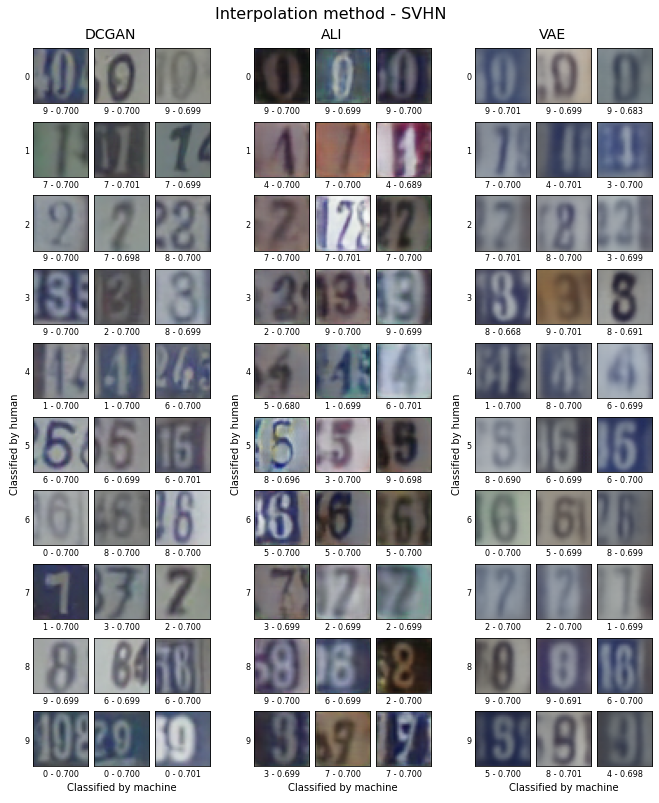

In [5]:
rows=10
cols=3
labelfont=8

# gridspec inside gridspec
fig = plt.figure(constrained_layout=True, figsize=(9, 11))
subfigs = fig.subfigures(1, 3, wspace=0.07)

data = load_selection(paths_int, 'SVHN', 'DCGAN')
for i in range(rows*cols):
    ax = subfigs[0].add_subplot(rows, cols, i+1)
    ax = plot_single_sample(ax, i, rows, cols, data, labelfont)
subfigs[0].suptitle(f"{data['model']}", size=14)

data = load_selection(paths_int, 'SVHN', 'ALI')
for i in range(rows*cols):
    ax = subfigs[1].add_subplot(rows, cols, i+1)
    ax = plot_single_sample(ax, i, rows, cols, data, labelfont)
subfigs[1].suptitle(f"{data['model']}", size=14)

data = load_selection(paths_int, 'SVHN', 'VAE')
for i in range(rows*cols):
    ax = subfigs[2].add_subplot(rows, cols, i+1)
    ax = plot_single_sample(ax, i, rows, cols, data, labelfont)
subfigs[2].suptitle(f"{data['model']}", size=14)

fig.suptitle('Interpolation method - SVHN', size=16)
fig.savefig('figures/int_samples_svhn.png', bbox_inches='tight')

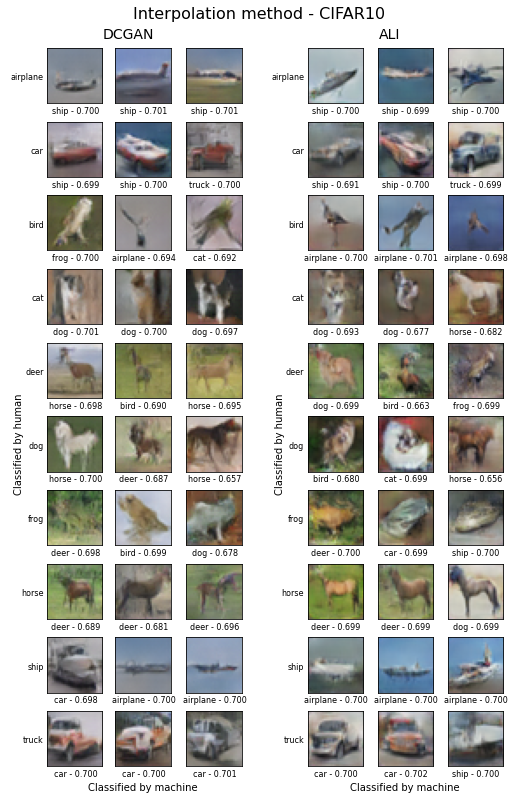

In [6]:
rows=10
cols=3
labelfont=8

# gridspec inside gridspec
fig = plt.figure(constrained_layout=True, figsize=(7, 11))
subfigs = fig.subfigures(1, 2, wspace=0.07)

data = load_selection(paths_int, 'CIFAR10', 'DCGAN')
for i in range(rows*cols):
    ax = subfigs[0].add_subplot(rows, cols, i+1)
    ax = plot_single_sample(ax, i, rows, cols, data, labelfont)
subfigs[0].suptitle(f"{data['model']}", size=14)

data = load_selection(paths_int, 'CIFAR10', 'ALI')
for i in range(rows*cols):
    ax = subfigs[1].add_subplot(rows, cols, i+1)
    ax = plot_single_sample(ax, i, rows, cols, data, labelfont)
subfigs[1].suptitle(f"{data['model']}", size=14)

fig.suptitle('Interpolation method - CIFAR10', size=16)
fig.savefig('figures/int_samples_cifar.png', bbox_inches='tight')

# Gradient method

In [7]:
paths_grad = {
    ('CIFAR10', 'DCGAN'): {
        'generator': r'..\runs\cifar10\dcgan-cifar',
        'sample': '..\samples\grad_sample_0-3_dcgan-cifar_999.pickle',
        'class_map': ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
        'selection': [
            478, 313, 653,
            1879, 1821, 1727,
            2220, 2733, 2210, 
            3337, 3091, 3226,
            4340, 4770, 4266,
            5379, 5725, 5212,
            6328, 6675, 6303,
            7581, 7129, 7314,
            8290, 8099, 8828,
            9143, 9207, 9032
        ]

    },
    ('CIFAR10', 'ALI'): {
        'generator': r'..\runs\cifar10\ali-cifar',
        'sample': '..\samples\grad_sample_0-3_ali-cifar_999.pickle',
        'class_map': ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
        'selection': [
            611, 659, 43,
            1528, 1871, 1611,
            2873, 2011, 2296,
            3514, 3250, 3112,
            4075, 4315, 4561,
            5206, 4973, 5513,
            6309, 6384, 6295,
            7199, 7738, 7004,
            8713, 8271, 7909,
            9569, 9249, 9375,
        ]
    },
    ('SVHN', 'ALI'): {
        'generator': r'..\runs\svhn\ali-svhn',
        'sample': '..\samples\grad_sample_0-3_ali-svhn_999.pickle',
        'class_map': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        'selection': [
            739, 182, 455,
            1093, 1079, 1240,
            2299, 1973, 2360,
            3272, 3359, 2566,
            4164, 4160, 3978,
            5093, 4433, 4913,
            5412, 5685, 5172,
            6672, 6052, 6309,
            7332, 6976, 6987,
            7923, 7965, 8777
        ]
    },
    ('SVHN', 'DCGAN'): {
        'generator': r'..\runs\svhn\dcgan-svhn',
        'sample': '..\samples\grad_sample_0-3_dcgan-svhn_999.pickle',
        'class_map': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        'selection': [
            513, 390, 792,
            1044, 1496, 1241,
            1978, 1866, 2218,
            2576, 2767, 3031,
            3941, 3906, 3968,
            4593, 4377, 4512,
            5509, 5286, 5597,
            6592, 6046, 6386,
            6780, 7258, 7052,
            7661, 7665, 7818
        ]
    },
    ('SVHN', 'VAE'): {
        'generator': r'..\runs\svhn\vae-svhn',
        'sample': '..\samples\grad_sample_0-3_vae-svhn_999.pickle',
        'class_map': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        'selection': [
            503, 908, 141,
            1258, 1615, 1295,
            2552, 2735, 2273,
            3252, 3092, 3172,
            4136, 4008, 4078,
            5098, 5059, 5655,
            5836, 6537, 6398,
            7340, 7356, 6936,
            8347, 8124, 8007,
            9623, 9497, 9427
        ]
    },
    ('MNIST', 'ALI'): {
        'generator': r'..\runs\mnist\ali-mnist',
        'sample': '..\samples\grad_sample_0-3_ali-mnist_999.pickle',
        'class_map': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        'selection': [
            226, 192, 115,
            805, 612, 837,
            1222, 1300, 1670,
            2274, 1853, 2292,
            2656, 2894, 2990,
            3674, 3137, 3451,
            3968, 3877, 4352,
            4865, 4486, 4540,
            5183, 5411, 5556,
            6581, 6068, 6257
        ]
    },
    ('MNIST', 'DCGAN'): {
        'generator': r'..\runs\mnist\dcgan-mnist',
        'sample': '..\samples\grad_sample_0-3_dcgan-mnist_999.pickle',
        'class_map': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        'selection': [
            43,  42, 183,
            885, 535, 564,
            1643, 1659, 1320,
            1855, 2180, 2225,
            2850, 2353, 2981,
            3554, 3083, 3610,
            4344, 4137, 4010,
            4657, 4453, 4945,
            5315, 5226, 5612,
            6337, 6108, 5724
        ]
    },
    ('MNIST', 'VAE'): {
        'generator': r'..\runs\mnist\vae-mnist',
        'sample': '..\samples\grad_sample_0-3_vae-mnist_999.pickle',
        'class_map': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        'selection': [
            215, 542, 595,
            1463, 855, 867,
            1692, 2288, 2013,
            3478, 3277, 3418,
            4355, 3853, 4140,
            5294, 4990, 5136,
            5475, 5891, 5718,
            6377, 6585, 6776,
            7711, 7219, 7760,
            8826, 8680, 8347
        ]
    }
}

### Success rate

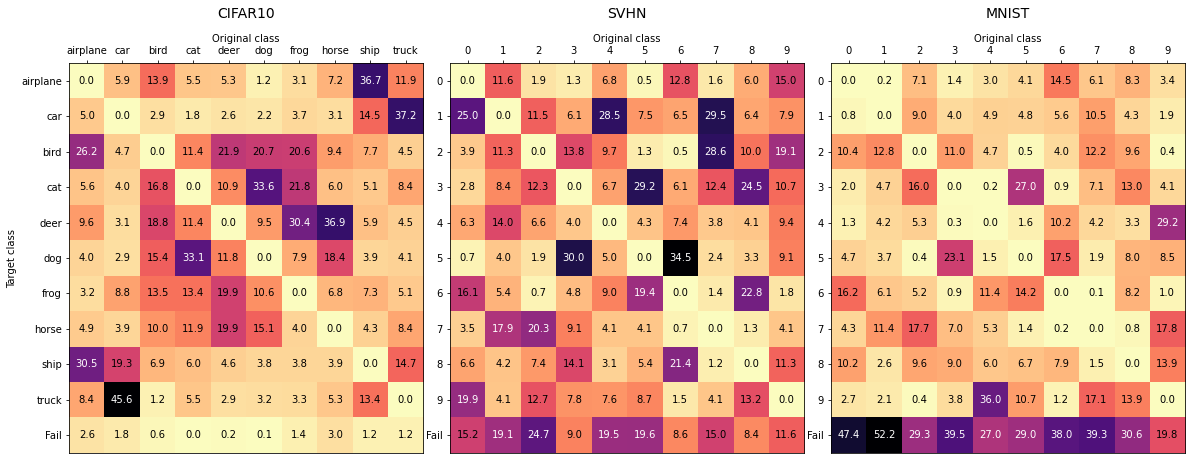

In [8]:
fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(1, 3)
gs.update(wspace=0.075)

ax0 = fig.add_subplot(gs[0])
dataset = 'CIFAR10'
matrix = get_matrix(paths_grad, dataset, 'DCGAN', include_fails=True, ylabel='Target class')
plot_matrix(ax0, matrix, title=dataset)

ax1 = fig.add_subplot(gs[1])
dataset = 'SVHN'
matrix = get_matrix(paths_grad, dataset, 'DCGAN', include_fails=True, ylabel='')
plot_matrix(ax1, matrix, title=dataset)

ax2 = fig.add_subplot(gs[2])
dataset = 'MNIST'
matrix = get_matrix(paths_grad, dataset, 'DCGAN', include_fails=True, ylabel='')
plot_matrix(ax2, matrix, title=dataset)

#fig.suptitle("Gradient method transformation statistics", size = 20, y=1)
fig.savefig('figures/grad_success_matrix.png', bbox_inches='tight')

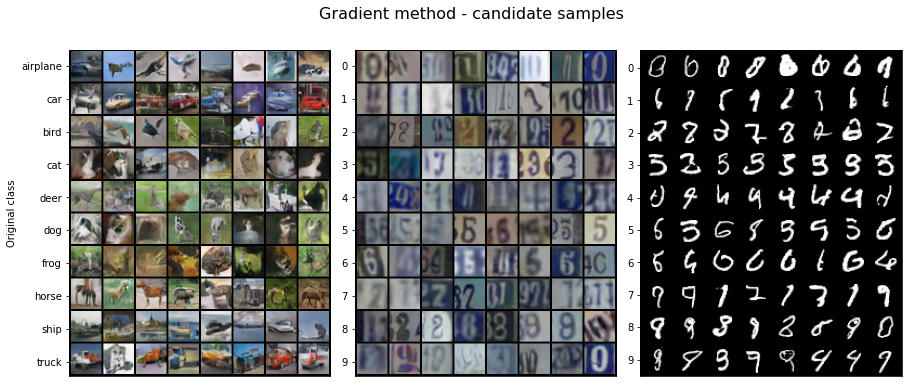

In [9]:
from torchvision.utils import make_grid
nrow=8
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(1, 3)
gs.update(wspace=0.075)
fig.suptitle('Gradient method - candidate samples', size=16)

# Plot data
data = load_selection(paths_grad, 'CIFAR10', 'DCGAN', samples=nrow)
grid = make_grid(torch.tensor(data['imgs']), nrow=nrow, normalize=True)
grid = np.transpose(grid.cpu().detach().numpy(), (1,2,0))

ax0 = fig.add_subplot(gs[0])
ax0.set_yticks(np.linspace(16, grid.shape[0]-16, 10))
ax0.set_yticklabels(data['class_map'])
ax0.set_xticks([])
ax0.set_ylabel('Original class')
ax0.imshow(grid)

# Plot data
data = load_selection(paths_grad, 'SVHN', 'DCGAN', samples=nrow)
grid = make_grid(torch.tensor(data['imgs']), nrow=nrow, normalize=True)
grid = np.transpose(grid.cpu().detach().numpy(), (1,2,0))

ax1 = fig.add_subplot(gs[1])
ax1.set_yticks(np.linspace(16, grid.shape[0]-16, 10))
ax1.set_yticklabels(data['class_map'])
ax1.set_xticks([])
ax1.imshow(grid)

# Plot data
data = load_selection(paths_grad, 'MNIST', 'DCGAN', samples=nrow)
grid = make_grid(torch.tensor(data['imgs']), nrow=nrow, normalize=True)
grid = np.transpose(grid.cpu().detach().numpy(), (1,2,0))

ax2 = fig.add_subplot(gs[2])
ax2.set_yticks(np.linspace(16, grid.shape[0]-16, 10))
ax2.set_yticklabels(data['class_map'])
ax2.set_xticks([])
ax2.imshow(grid)
fig.savefig('figures/grad_candidates.png', bbox_inches='tight')

### Selected adversarial examples

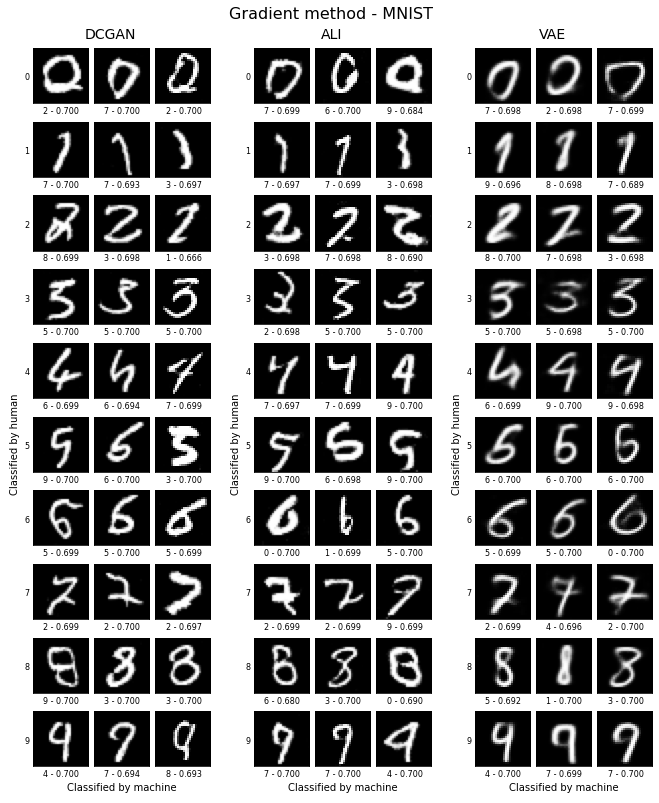

In [10]:
rows=10
cols=3
labelfont=8

# gridspec inside gridspec
fig = plt.figure(constrained_layout=True, figsize=(9, 11))
subfigs = fig.subfigures(1, 3, wspace=0.07)

data = load_selection(paths_grad, 'MNIST', 'DCGAN')
for i in range(rows*cols):
    ax = subfigs[0].add_subplot(rows, cols, i+1)
    ax = plot_single_sample(ax, i, rows, cols, data, labelfont, grayscale=True)
subfigs[0].suptitle(f"{data['model']}", size=14)

data = load_selection(paths_grad, 'MNIST', 'ALI')
for i in range(rows*cols):
    ax = subfigs[1].add_subplot(rows, cols, i+1)
    ax = plot_single_sample(ax, i, rows, cols, data, labelfont, grayscale=True)
subfigs[1].suptitle(f"{data['model']}", size=14)

data = load_selection(paths_grad, 'MNIST', 'VAE')
for i in range(rows*cols):
    ax = subfigs[2].add_subplot(rows, cols, i+1)
    ax = plot_single_sample(ax, i, rows, cols, data, labelfont, grayscale=True)
subfigs[2].suptitle(f"{data['model']}", size=14)

fig.suptitle('Gradient method - MNIST', size=16)
fig.savefig('figures/grad_samples_mnist.png', bbox_inches='tight')

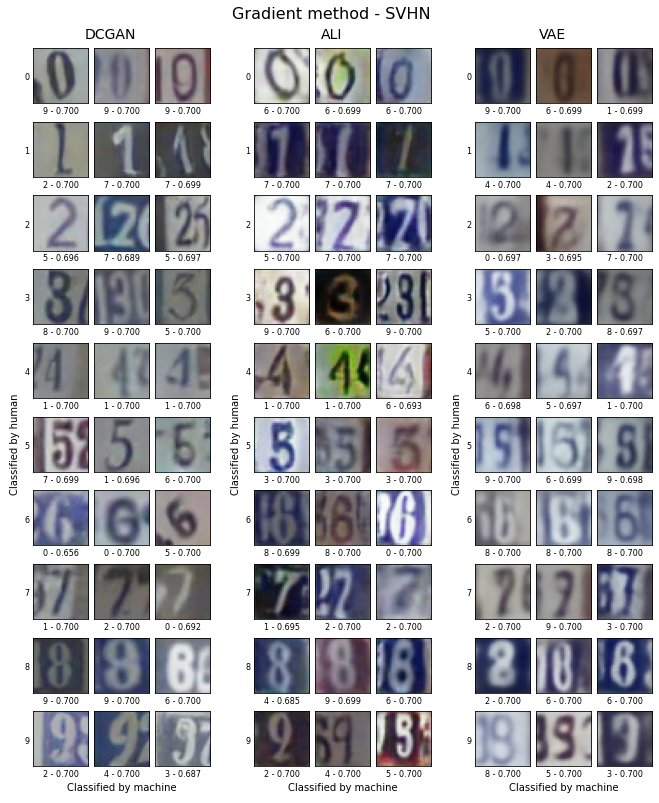

In [11]:
rows=10
cols=3
labelfont=8
fig = plt.figure(constrained_layout=True, figsize=(9, 11))
subfigs = fig.subfigures(1, 3, wspace=0.07)

data = load_selection(paths_grad, 'SVHN', 'DCGAN')
for i in range(rows*cols):
    ax = subfigs[0].add_subplot(rows, cols, i+1)
    ax = plot_single_sample(ax, i, rows, cols, data, labelfont)
subfigs[0].suptitle(f"{data['model']}", size=14)

data = load_selection(paths_grad, 'SVHN', 'ALI')
for i in range(rows*cols):
    ax = subfigs[1].add_subplot(rows, cols, i+1)
    ax = plot_single_sample(ax, i, rows, cols, data, labelfont)
subfigs[1].suptitle(f"{data['model']}", size=14)

data = load_selection(paths_grad, 'SVHN', 'VAE')
for i in range(rows*cols):
    ax = subfigs[2].add_subplot(rows, cols, i+1)
    ax = plot_single_sample(ax, i, rows, cols, data, labelfont)
subfigs[2].suptitle(f"{data['model']}", size=14)

fig.suptitle('Gradient method - SVHN', size=16)
fig.savefig('figures/grad_samples_svhn.png', bbox_inches='tight')

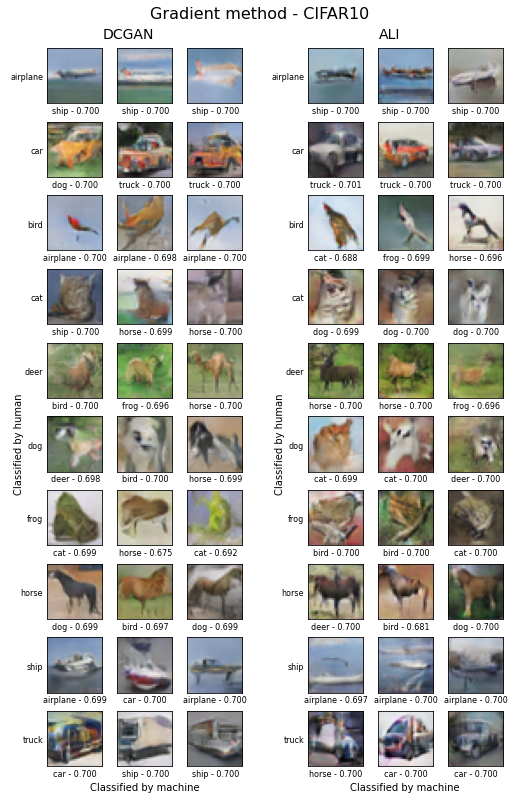

In [12]:
rows=10
cols=3
labelfont=8
fig = plt.figure(constrained_layout=True, figsize=(7, 11))
subfigs = fig.subfigures(1, 2, wspace=0.07)

data = load_selection(paths_grad, 'CIFAR10', 'DCGAN')
for i in range(rows*cols):
    ax = subfigs[0].add_subplot(rows, cols, i+1)
    ax = plot_single_sample(ax, i, rows, cols, data, labelfont)
subfigs[0].suptitle(f"{data['model']}", size=14)

data = load_selection(paths_grad, 'CIFAR10', 'ALI')
for i in range(rows*cols):
    ax = subfigs[1].add_subplot(rows, cols, i+1)
    ax = plot_single_sample(ax, i, rows, cols, data, labelfont)
subfigs[1].suptitle(f"{data['model']}", size=14)

fig.suptitle('Gradient method - CIFAR10', size=16)
fig.savefig('figures/grad_samples_cifar.png', bbox_inches='tight')

# Attacking robust classifiers with gradient method

In [13]:
paths_madry = {
    ('MNIST - Robust classifier', 'DCGAN'): {
        'generator': r'..\runs\mnist\dcgan-mnist',
        'sample': '..\samples\grad_sample_madry_robust_0-3_dcgan-mnist_999.pickle',
        'class_map': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        'selection': [            
            46, 36, 25, 131, 188,
            366, 384, 420, 529, 493,
            692, 643, 669, 770, 810,
            1160, 1165, 1151, 1169, 1135,
            1724, 1730, 1738, 1689, 1668,
            2077, 2129, 2121, 2115, 2133,
            2640, 2672, 2604, 2493, 2560,
            2879, 2956, 2950, 2940, 2888,
            3273, 3345, 3278, 3272, 3312,
            3737, 3747, 3726, 3759, 3733
            ]

    },
    ('MNIST - Basic classifier', 'DCGAN'): {
        'generator': r'..\runs\mnist\dcgan-mnist',
        'sample': '..\samples\grad_sample_madry_natural_0-3_dcgan-mnist_999.pickle',
        'class_map': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    }
}

### Success rate 
- compared to model without adversarial training

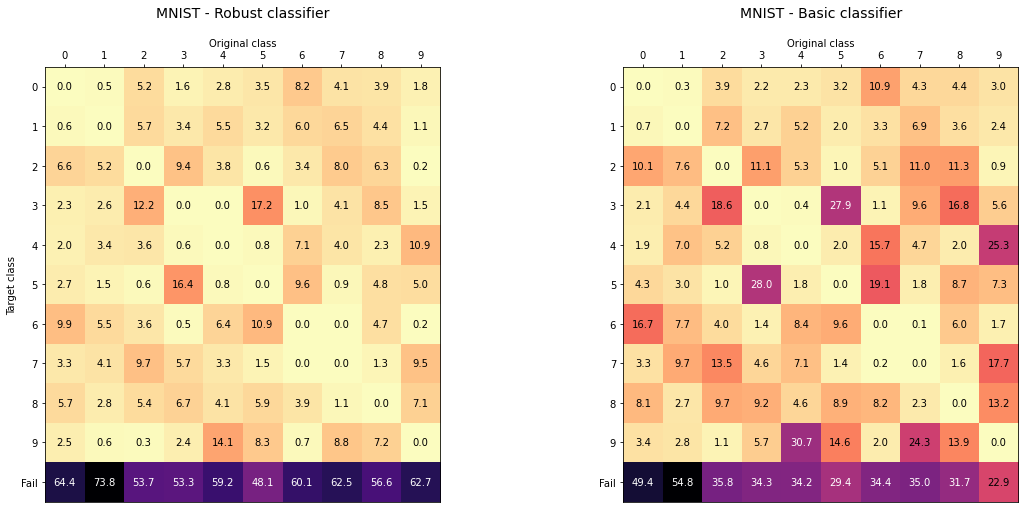

In [14]:
fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.075)

ax0 = fig.add_subplot(gs[0])
dataset = 'MNIST - Robust classifier'
matrix = get_matrix(paths_madry, dataset, 'DCGAN', include_fails=True, ylabel='Target class')
plot_matrix(ax0, matrix, title=dataset)

ax1 = fig.add_subplot(gs[1])
dataset = 'MNIST - Basic classifier'
matrix = get_matrix(paths_madry, dataset, 'DCGAN', include_fails=True, ylabel='')
plot_matrix(ax1, matrix, title=dataset)
fig.savefig('figures/grad_success_matrix_robust.png', bbox_inches='tight')

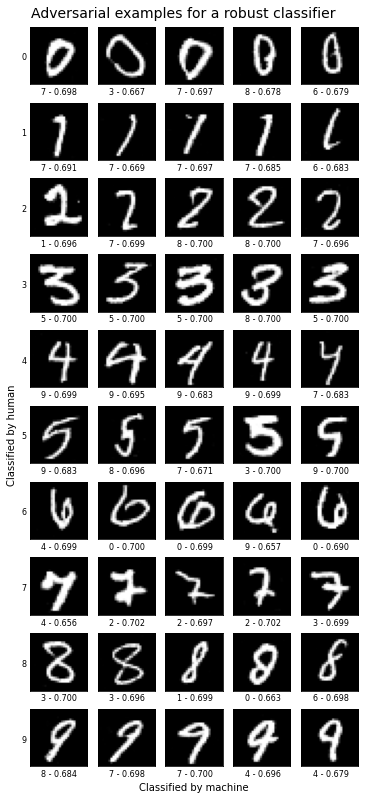

In [15]:
fig = plt.figure(constrained_layout=True, figsize=(5, 11))
rows = 10
cols = 5
data = load_selection(paths_madry, 'MNIST - Robust classifier', 'DCGAN')
for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    ax = plot_single_sample(ax, i, rows, cols, data, labelfont=8, grayscale=True)
fig.suptitle(f"Adversarial examples for a robust classifier", size=14)
fig.savefig('figures/grad_samples_mnist_robust.png', bbox_inches='tight')